# Autoencodery dla kategorii

##### Importy

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model

#### Przygotowanie danych

In [2]:
df = pd.read_csv('selected_data.csv')
df.loc[:,"1991":"2021"] = df.loc[:,"1991":"2021"].interpolate('linear', axis =1, limit_direction='both')


In [3]:
def min_max_scaling_by_specific_category(data):
    scaled_df = data.copy()
    general_categories = scaled_df['Category Name'].unique()
    scaler = MinMaxScaler()
    for general_category in general_categories:
        # Sprawdzamy, jakie kategorie szczegółowe zawierają daną kategorię ogólną
        specific_categories = scaled_df.loc[scaled_df['Category Name'] == general_category, 'Indicator Name'].unique()
        for specific_category in specific_categories:
            # Wybieramy dane dla danej kategorii ogólnej i wybranej kategorii szczegółowej
            selected_data = scaled_df[(scaled_df['Category Name'] == general_category) & (scaled_df['Indicator Name'] == specific_category)]
            # Wybieramy tylko kolumny numeryczne do skalowania
            numeric_cols = selected_data.select_dtypes(include=['float64', 'int64']).columns
            data_to_scale = selected_data[numeric_cols]
            # Przeprowadzamy skalowanie
            if len(data_to_scale.columns) > 0:
                scaled_data = scaler.fit_transform(data_to_scale)
                scaled_df.loc[selected_data.index, numeric_cols] = scaled_data
    
    return scaled_df

In [4]:
df_scaled = min_max_scaling_by_specific_category(df)
selected_columns = df_scaled.loc[:,"1991":"2021"]
row_mean = selected_columns.mean(axis=1)
df_scaled['Mean'] = row_mean
select_columns = ['Country Name','Category Name','Indicator Name', 'Mean']
X_scaled_df = df_scaled[select_columns]
X = X_scaled_df.select_dtypes(include=['float64', 'int64'])

#### Podział na kategorie

In [5]:
categories = X_scaled_df['Category Name'].unique()

In [6]:
models = {}

#### Tworzenie autoencodera dla kazdej z kategorii 

In [7]:
for category in categories:
    # Wybór danych dla kategorii
    X_category = X[X_scaled_df['Category Name']==category]
    
    # Podział na zbiór traningowy i testowy
    X_train, X_test = train_test_split(X_category, test_size=0.1,random_state=42)
    
    # Autoencoder
    input_layer = Input(shape=(X_category.shape[1],))
    encoded = Dense(64, activation='relu')(input_layer)
    decoded = Dense(X_category.shape[1],activation='sigmoid')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer = 'Adam',loss='mean_squared_error')
    
    # Trenowanie autoencodera
    autoencoder.fit(X_train, X_train, epochs=75, batch_size=14, validation_data=(X_test,X_test))
    
    # zapisanie modelu
    models[category] = autoencoder

Epoch 1/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0851 - val_loss: 0.1059
Epoch 2/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0797 - val_loss: 0.1016
Epoch 3/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0811 - val_loss: 0.0973
Epoch 4/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0827 - val_loss: 0.0931
Epoch 5/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0699 - val_loss: 0.0888
Epoch 6/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0616 - val_loss: 0.0846
Epoch 7/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0630 - val_loss: 0.0800
Epoch 8/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0583 - val_loss: 0.0755
Epoch 9/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0632 - val_loss: 0.0708
Epoch 10/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0515 - val_loss: 0.0662
Epoch 11/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0470 - val_loss: 0.0616
Epoch 12/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454 - val_lo

#### Wizualizacja jak autoencoder nauczył się rekonstruować dane

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


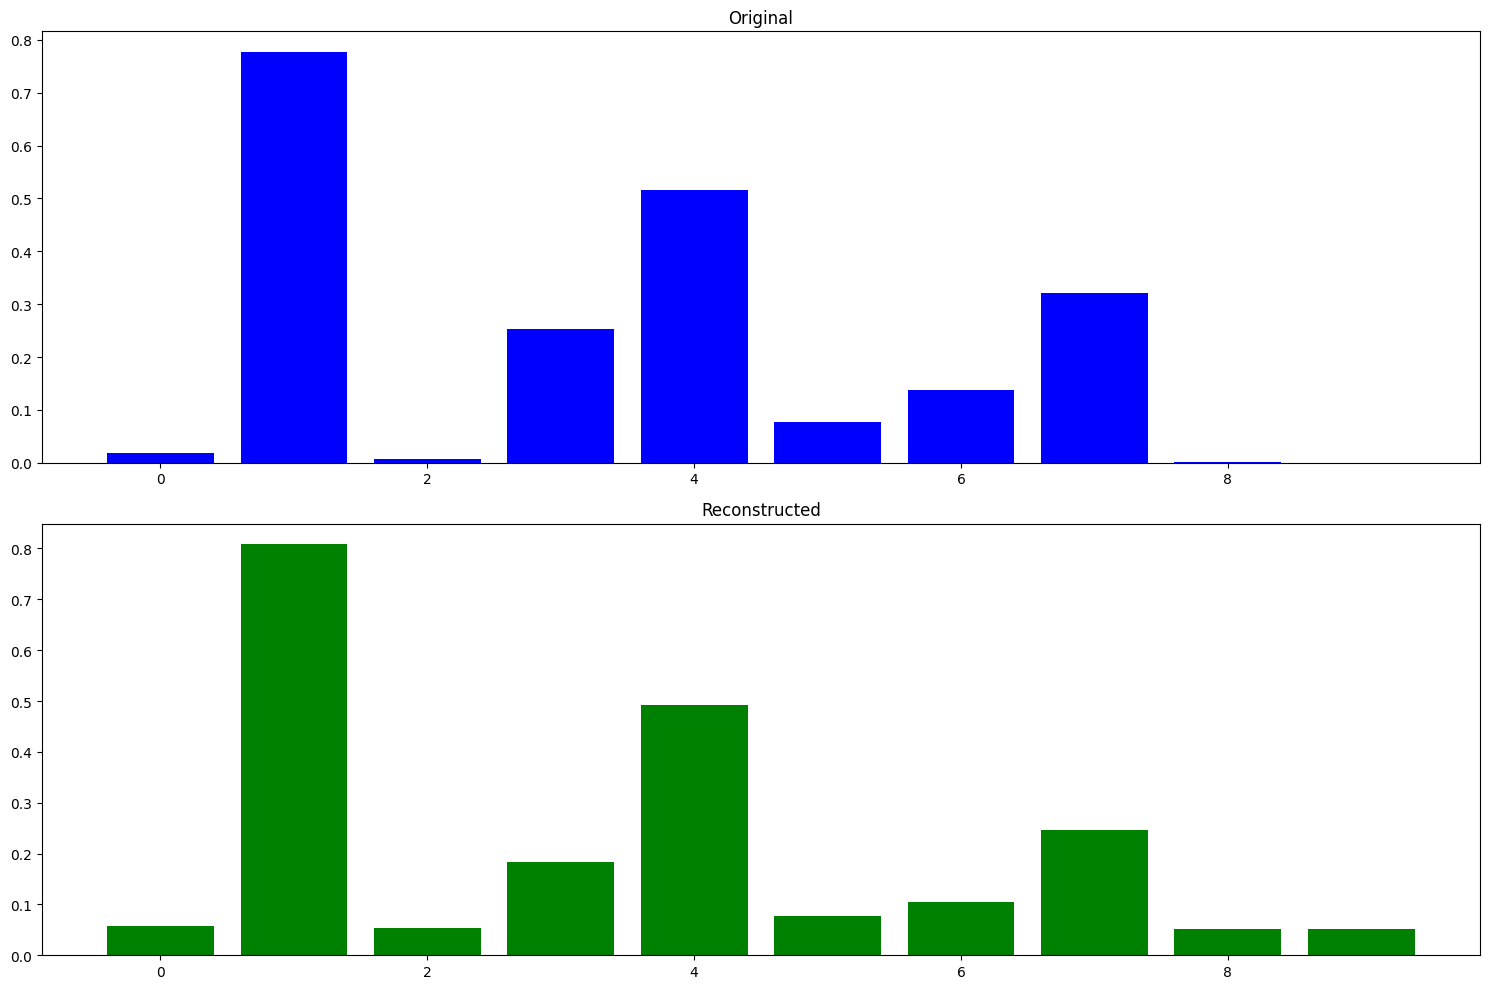

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Wybieranie kilku próbek z danych testowych
n_samples = 10
test_samples = X_test[:n_samples]

# tworzenie wykresu
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Odtworzenie danych za pomocą autoencodera
reconstructed_samples = autoencoder.predict(test_samples)

for i in range(n_samples):
    # Wybranie jednej próbki z danych testowych
    test_sample = test_samples.iloc[i]
    reconstructed_sample = reconstructed_samples[i]

    # Wyświetlenie oryginalych danych
    axs[0].bar(i, np.mean(test_sample), color='b')

    # Wyświetlenie odtworzonych danych
    axs[1].bar(i, np.mean(reconstructed_sample), color='g')

axs[0].set_title("Original")
axs[1].set_title("Reconstructed")

plt.tight_layout()
plt.show()
